# Image Filters
This notebook aims to show the math behind different common filters in deep learning.  The filters shown in this notebook are:
1. Convolution operation
  * Performed with:
    * Scipy
    * Tensorflow
2. Laplacian sharpening filter
3. Series of filters on the same image  
  1. Laplacian filter
  2. Sobel filter in x-direction
  3. Sobel filter in y-direction
  4. Canny filter for edge detection

## Convolution

**Full vs Valid Convolution:**
* Valid
  * Only move the filter over the image and do not fill in the boundary values.  This means you lose some information along the boundary of the image (for example a 6 by 6 image becomes 4 by 4 with a 3 by 3 filter and stride of 1)
    * Final image dimensions: $[I_{w} - (F_{w}-s)] \times [I_{h} - (F_{h} - s)]$
      * s = stride (usually 1), I = orginal image, F = filter
* Full
  * Also computes the boundary values of the image
    * Begin with the top left corner of the image and bottom right corner of the filter overlapping.  This means your final image is actually going to be larger in size.
  * Assumes the values are zero where the image and filter do not overlap
  * Final image dimensions: $[I_{w} + (F_{w}-s)] \times [I_{h} + (F_{h} - s)]$      

**Gaussian filters:**  
The gaussian filter is a neighborhood (n by n) which in this case is 3 by 3.  These filters are also called kernels, masks, templates, or windows. We will perform the convolution operation on the 3 by 3 neighborhood in this case.

*Properties of a gaussian filter:*
* Center pixel has the highest value
* Low pass filter
  * Allows lower frequncies to pass
  * Removes high frequency data

*Average Filter:*
* Computes average of the neighborhood
* example: c * ones(n,n)

Both average and gaussian filters have a similar effect on an image

c is the normalizing constant, which means it is a 1/x value that is used to ensure that the output image value is within the 0-255 range. 



### Scipy
sg.convolve does the trick

In [1]:
from scipy import signal as sg
image = [[97,52,99,62,69,45,70],[99,14,60,50,74,45,22],
                     [59,72,74,14,74,100,28],[28,8,47,85,2,88,77],
                     [74,6,30,87,49,22,43],[86,87,4,53,36,10,46],
                     [54,7,67,23,29,26,15]]
gaussian_filter = [[1,2,1],[2,4,1],[1,2,1]]

# Perform full and valid concolution
print("Full Convolution from Scipy:")
full_convolution = sg.convolve(image, gaussian_filter)
print(full_convolution)
print("-----------------")
print("Valid Convolution from Scipy:")
valid_convolution = sg.convolve(image,gaussian_filter,"valid")
print(valid_convolution)

Full Convolution from Scipy:
[[ 97 246 300 312 292 245 229 185  70]
 [293 704 690 756 719 671 575 414  92]
 [354 860 852 900 876 943 829 474 120]
 [245 656 773 767 731 930 971 543 127]
 [189 472 547 753 820 738 946 660 148]
 [262 631 513 635 841 639 580 538 166]
 [300 787 693 526 683 531 400 358 104]
 [194 489 480 469 363 326 265 188  61]
 [ 54 115 135 164 142 107  96  56  15]]
-----------------
Valid Convolution from Scipy:
[[852 900 876 943 829]
 [773 767 731 930 971]
 [547 753 820 738 946]
 [513 635 841 639 580]
 [693 526 683 531 400]]


### TensorFlow

tf.nn.conv2d is the go to method for applying convolution on a 2d image in tensorflow.  Something to note is that it takes as input: tf.nn.conv2d(image_reshaped, filter_reshaped, strides = [a,b,c,d], padding = "SAME" or "VALID").  
The strides and padding inputs are fairly straightforward. strides is usually equal to [1,1,1,1], so you take a single step in each of the dimensions.  padding input SAME tells us to keep the image size the same, or perform full convolution.    
There are certain idiocyncracies about the reshaped images and filters for the conv2d 

In [2]:
import tensorflow as tf

image = tf.constant([[97,52,99,62,69,45,70],[99,14,60,50,74,45,22],
                     [59,72,74,14,74,100,28],[28,8,47,85,2,88,77],
                     [74,6,30,87,49,22,43],[86,87,4,53,36,10,46],
                     [54,7,67,23,29,26,15]])
gaussian_filter = tf.constant([[1,2,1],[2,4,1],[1,2,1]])   

# Reshape input tensors
input_reshape = tf.reshape(image, [1,7,7,1])
gaussian_filter_reshape = tf.reshape(gaussian_filter, [3,3,1,1])

# Print initial and reshaped tensor shapes
print("Input image shapes:")
print("Original shape: ",image.shape)
print("Resized shape: ", input_reshape.shape)
print("------------")
print("Gaussian filter shapes:")
print("Original shape: ",gaussian_filter.shape)
print("Resized shape: ", gaussian_filter_reshape.shape)

Input image shapes:
Original shape:  (7, 7)
Resized shape:  (1, 7, 7, 1)
------------
Gaussian filter shapes:
Original shape:  (3, 3)
Resized shape:  (3, 3, 1, 1)


In [3]:
op1 = tf.nn.conv2d(input_reshape,gaussian_filter_reshape,
                   strides=[1,1,1,1], padding='VALID')
op2 = tf.nn.conv2d(input_reshape,gaussian_filter_reshape,
                   strides=[1,1,1,1], padding='SAME')

print("conv2d output shapes:")
print("Valid convolution: ", op1.shape)
print("Full Convolution: ",op2.shape)
print("------------")
print("Reshaped tensors:")
print(tf.reshape(op1, [5,5]))
print(tf.reshape(op2, [7,7]))

conv2d output shapes:
Valid convolution:  (1, 5, 5, 1)
Full Convolution:  (1, 7, 7, 1)
------------
Reshaped tensors:
tf.Tensor(
[[ 891  864  862  948  881]
 [ 758  825  731  844 1017]
 [ 528  676  865  735  871]
 [ 557  554  822  704  586]
 [ 775  560  651  574  390]], shape=(5, 5), dtype=int32)
tf.Tensor(
[[ 652  688  746  749  688  574  459]
 [ 846  891  864  862  948  881  519]
 [ 584  758  825  731  844 1017  643]
 [ 464  528  676  865  735  871  748]
 [ 625  557  554  822  704  586  560]
 [ 700  775  560  651  574  390  368]
 [ 482  467  453  401  323  279  214]], shape=(7, 7), dtype=int32)


## Laplacian Filter

**Laplacian Filter Math:**
$$ \nabla^2f(x,y) = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$$

$$\nabla^2f(x,y)= f(x+1,y) + f(x-1,y) + f(x,y+1) + f(x,y-1) - 4f(x,y)$$

Since this equation is applied to an image, we are applying a discrete definition to the function f(x,y), meaning the function is refering to specific pixels within the image or filter:

<img src="https://drive.google.com/uc?id=1BNfyhsX8aBu9IrKjN9dbnLYSXKdm8d5L" width="400" height="200" />

**Image output:**  
* Laplacian filter produces a sharp image with a dark background
* To generate an image with details, add or subtract the filtered image from the original:  
$$ g(x,y) = f(x,y) \pm \nabla^2f(x,y)$$

**Notes about equation:**  
*First order derivative of a discrete function:*
$$\frac{\partial f(x)}{\partial x} = f(x+1) - f(x)$$

*Second order derivative of a one-dimensional discrete function:*
$$\frac{\partial^2 f(x)}{\partial x^2} = f(x+1) - f(x) - (f(x) - f(x-1)) = f(x+1) + f(x-1) -2f(x)$$
The second order derivative can be thought of as the difference between between two adjacent first-order derivatives.

Naturally, when taking a first derivative of an array f with n = 10, the array f' (first derivative) will end up being n = 9.  The array f'' will end up being n = 8.

**Meaning of derivatives in the context of edge detection:**
* First derivatives
  * =0 &#8594; flat segment
  * !=0 &#8594; onset of gray-level step or ramp
    * occurs along ramps
  * Thicker edges
  * Gray-level steps
* Second derivatives
  * =0 &#8594; flat areas
    * occurs along ramps or constant slopes
  * !=0 &#8594; onset and end of a gray-level step or ramp
  * Thin lines
  * Isolated points
  * Double response at step changes
  * Better suited than first derivative for image enhancement since it enhances finer details


In [18]:
cd 'Image Filters'

/content/drive/My Drive/Colab Notebooks/Caltech TensorFlow Intro/Image Filters


In [19]:
ls

filters.ipynb  laplacian_filter.png  rice.png


In [6]:
from google.colab import files #upload file from computer to google cloud server
from google.colab import drive #authorize colab to use your drive
# drive.mount('/content/drive')
# uploaded = files.upload()

KeyboardInterrupt: ignored

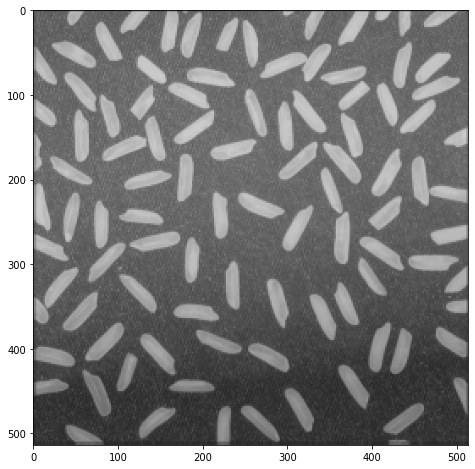

In [21]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Various filters to try out
l_filter_1 = np.array([[0,1,0],[1,-4,1],[0,1,0]])
l_filter_2 = np.array([[1,1,1],[1,-8,1],[1,1,1]])
l_filter_3 = np.array([[0,1,0],[1,-5,1],[0,1,0]])
l_filter_4 = np.array([[1,1,1],[1,-9,1],[1,1,1]])

# Read the image file
im = Image.open('rice.png')
fig,aux = plt.subplots(figsize = (8,8))
aux.imshow(im, cmap = 'gray')

In [ ]:
image_gr = im.convert("L")
arr = np.asarray(image_gr)

# Apply the convolution filter
grad = signal.convolve2d(arr,l_filter_1, mode = 'same', boundary = 'symm')
fig,aux = plt.subplots(figsize = (8,8))
aux.imshow(np.absolute(grad), cmap = 'gray')

## Series of Filters

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


4.1.2


In [23]:
laplacian = cv2.Laplacian(img, cv2.CV_64F, ksize = 11)

NameError: ignored